Dear learning rate...

I will look for you, I will find you, and I will ???? you

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import SGD
from functools import partial
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader

# local imports
import sys
sys.path.insert(1, '../')
from modules.dsets import TrainingCovid2dSegmentationDataset, collate_fn
from modules.model import UNet3dWrapper, CovidSegNetWrapper
from modules.util.util import list_stride_splitter
from modules.util.loss_funcs import dice_loss, cross_entropy_loss

In [4]:
torch.cuda.empty_cache()

## Basic Unet 3D

In [3]:
model = UNet3dWrapper(
    in_channels=1,
    n_classes=1,
    depth=3,
    wf=4,
    padding=True,
    pad_type='replicate',
    batch_norm=True,
    up_mode='upconv')
model = model.cuda()

In [4]:
lr = 1e-7
momentum=.99
weight_decay=1e-4
optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [6]:
def dice_loss_func(pred_g, label_g, epsilon=1):
    dice_correct = (pred_g * label_g).sum(dim=[-4,-3,-2,-1])
    dice_label_g = label_g.sum(dim=[-4,-3,-2,-1])
    dice_pred_g = pred_g.sum(dim=[-4,-3,-2,-1])

    dice_ratio = (2 * dice_correct + epsilon) \
        / (dice_label_g + dice_pred_g + epsilon)
    return 1 - dice_ratio

def loss_func(pred_g, label_g):
    dice_loss = dice_loss_func(pred_g, label_g)
    #fine_loss = dice_loss_func(pred_g*label_g, label_g)
    
    return dice_loss.mean()# + fine_loss.mean() * 8

criterion = loss_func

In [6]:
splitter=partial(list_stride_splitter, val_stride=10)

train_ds = TrainingCovid2dSegmentationDataset(
    is_valid=False, 
    splitter=splitter,
    width_irc=(12,192,192))

batch_size = 2

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

2020-11-29 21:17:21,713 INFO     pid:31010 modules.dsets:316:__init__ TrainingCovid2dSegmentationDataset: training mode, 179 uid's
2020-11-29 21:17:21,713 INFO     pid:31010 modules.dsets:341:__init__ TrainingCovid2dSegmentationDataset: (12, 192, 192) width_irc,  160 steps_per_epoch


In [7]:
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')

In [8]:
lr_finder.range_test(train_loader=train_dl, end_lr=10, num_iter=100)


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.38E-01


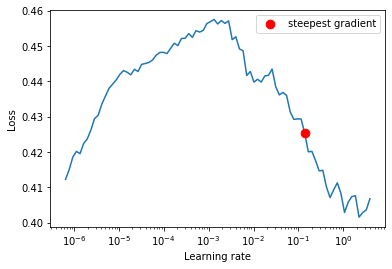

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8e84524310>,
 0.13848863713938717)

In [9]:
# this was for model with depth 3, width_irc = 7,60,60
lr_finder.plot() 

In [10]:
lr_finder.reset()

## Covid Seg Net

In [5]:
model = CovidSegNetWrapper(
    in_channels=1,
    n_classes=2,
    depth=3,
    wf=4,
    padding=True)
model = model.cuda()

In [6]:
lr = 1e-7
momentum=.99
weight_decay=1e-4
optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [7]:
def loss_func(pred_g, label_g):
    ce_loss = cross_entropy_loss(pred_g, torch.squeeze(label_g, dim=1).long())
    d_loss = dice_loss(torch.argmax(pred_g, dim=1, keepdim=True).float(), label_g)
    return ((ce_loss + d_loss) * .5).mean()

criterion = loss_func

In [9]:
splitter=partial(list_stride_splitter, val_stride=5)

train_ds = TrainingCovid2dSegmentationDataset(
    is_valid=False, 
    splitter=splitter,
    width_irc=(16,128,128))

batch_size = 2

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

2020-11-29 23:59:24,179 INFO     pid:42597 modules.dsets:316:__init__ TrainingCovid2dSegmentationDataset: training mode, 159 uid's
2020-11-29 23:59:24,179 INFO     pid:42597 modules.dsets:341:__init__ TrainingCovid2dSegmentationDataset: (16, 128, 128) width_irc,  160 steps_per_epoch


In [10]:
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')

In [11]:
lr_finder.range_test(train_loader=train_dl, end_lr=10, num_iter=100)


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.67E-01


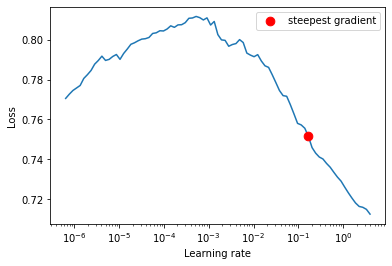

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8b774facd0>, 0.1668100537200059)

In [12]:
lr_finder.plot() 

In [12]:
lr_finder.reset()